### **CAPTCHA pildilt tähemärkide tuvastamine**

In [ ]:
# Colabi jaoks vajalikud impordid
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Mounted at /content/drive


In [ ]:
# Moodulite installeerimine ja importimine
!pip install accelerate -q

import cv2 as cv
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Colabis vajalik teek piltide näitamiseks
from google.colab.patches import cv2_imshow

# Pildid
from PIL import Image
import re
from keras.preprocessing.image import img_to_array, ImageDataGenerator

# Närvivõrgud
import tensorflow.keras
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Activation, MaxPooling2D, Flatten, Conv2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.5 MB/s eta 0:00:00


### Andmete eeltöötlus

In [ ]:
# Piltide sisselugemine
image_names = []
images = []
labels = []

folder_path = '/content/drive/My Drive/Colab Notebooks/data_captcha/'

for filename in os.listdir(folder_path):
    # Igaks juhuks salvestame pildifailide nimed järjendisse
    image_names.append(filename)
    # Pildid salvestame eraldi järjendisse
    img = cv.imread(os.path.join(folder_path, filename), cv.IMREAD_GRAYSCALE) # IMREAD_GRAYSCALE kasutamise idee allikas: https://www.kaggle.com/code/vontelasanjana/captcha-95-accuracy
    images.append(img)
    # Eraldame pildi labeli ehk lahenduse ja salvestame selle eraldi järjendisse
    label = re.split(r'\.png$|\.jpg$', filename)[0]
    labels.append(label)

label: 43xfe


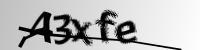


label: 3d7bd


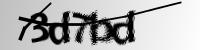


label: 3w2bw


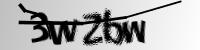


label: 3xng6


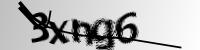


label: 3nfdn


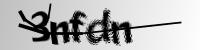

In [ ]:
# Vaatame viis esimest CAPTCHA pilti

for i in range(5):
  print("label:", labels[i])
  cv2_imshow(images[i])
  print()

In [ ]:
# Pildi eeltöötlus nagu mudeli treenimisel

def img_preprocessing(img):
  kernel = np.ones((2,2), np.uint8)
  image = cv.dilate(img, kernel, iterations = 3)
  #cv2_imshow(image)
  # Eemaldab pildilt hallikad tooonid
  image = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 145, 6)
  # Hägustamine müra vähendamiseks
  image = cv.GaussianBlur(image, (5,5), 0)
  return image

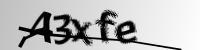

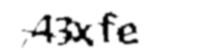

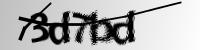

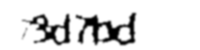

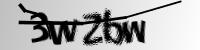

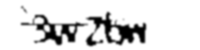

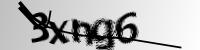

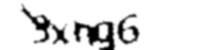

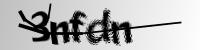

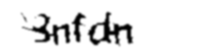

In [ ]:
# Piltide töötlemine
# Kasutatud morfoloogilised teisenduste ideid sain 9. praktikumist ja siit -> https://www.kaggle.com/code/vontelasanjana/captcha-95-accuracy
# 200 x 50 pildid

preproc_images = []
for img in images:
  image = img_preprocessing(img)
  preproc_images.append(image)

for i in range(5):
  cv2_imshow(images[i])
  cv2_imshow(preproc_images[i])

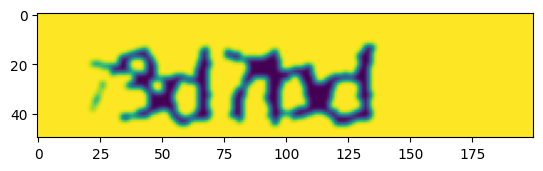

In [ ]:
plt.imshow(preproc_images[1]) # Siit saab leida ligikaudsed vahemikud, mis vastavad erinevatele tähemärkidele

In [ ]:
# Idee, kuidas jagada pildid tähemärkideks sain siit -> https://www.kaggle.com/code/vontelasanjana/captcha-95-accuracy

X = []
y = []
for i in range(len(preproc_images)):
  # Jagame pildi tähemärkide osadeks
  image = preproc_images[i]
  x = [image[10:50,30:50],image[10:50,50:70],image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]
  #cv2_imshow(x[0])

  path = os.path.join(folder_path, image_names[i])
  # Lisame pildi osadele vastavusse tähemärgid
  for j in range(5):
    X.append(img_to_array(Image.fromarray(x[j])))
    symbol = labels[i][j]
    y.append(symbol)

X=np.array(X)
y=np.array(y)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normaliseerimine, et X väärtused paikneksid nulli ümber

# Muudame X-i 2D järjendiks (samples, height * width * channels)
num_samples, height, width, channels = X.shape
X_reshaped = X.reshape((num_samples, height * width * channels))

# Kasutame MinMaxScaler-it
scaler = MinMaxScaler()
X_reshaped_norm = scaler.fit_transform(X_reshaped)

# Muudame X-i tagasi 4D järjendiks
X_norm = X_reshaped_norm.reshape((num_samples, height, width, channels))

# y vektoriseerimise tegin näite järgi -> https://www.kaggle.com/code/vontelasanjana/captcha-95-accuracy
encoder = LabelEncoder().fit_transform(y)
one_hot_vec = OneHotEncoder(sparse = False).fit_transform(encoder.reshape(len(encoder), 1))

X_train, X_test, y_train, y_test = train_test_split(X_norm, one_hot_vec, test_size = 0.1, shuffle=True)

row, col = X.shape[1], X.shape[2]
categories = one_hot_vec.shape[1]

info = {encoder[i] : y[i] for i in range(len(y))}

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Mudeli koostamine

In [ ]:
# Kihtide valikul, mis sobiksid minu ülesandega sain ideid siit -> https://www.kaggle.com/code/vontelasanjana/captcha-95-accuracy

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same', input_shape=(row,col,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dropout(0.6))
model.add(Dense(1000))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(categories))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 20, 16)        160       
                                                                 
 batch_normalization (Batch  (None, 40, 20, 16)        64        
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 40, 20, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 10, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 10, 16)        2320      
                                                                 
 batch_normalization_1 (Bat  (None, 20, 10, 16)        6

In [ ]:
batch_size = 64
epochs = 20

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test)) #, shuffle=True

Epoch 1/20
76/76 [==============================] - 12s 128ms/step - loss: 2.5209 - accuracy: 0.2150 - val_loss: 2.8761 - val_accuracy: 0.0953
Epoch 2/20
76/76 [==============================] - 10s 130ms/step - loss: 1.6219 - accuracy: 0.4930 - val_loss: 2.5886 - val_accuracy: 0.2374
Epoch 3/20
76/76 [==============================] - 9s 115ms/step - loss: 1.2626 - accuracy: 0.6096 - val_loss: 2.4241 - val_accuracy: 0.1701
Epoch 4/20
76/76 [==============================] - 9s 114ms/step - loss: 1.0442 - accuracy: 0.6829 - val_loss: 1.9103 - val_accuracy: 0.3664
Epoch 5/20
76/76 [==============================] - 4s 52ms/step - loss: 0.9298 - accuracy: 0.7115 - val_loss: 1.5010 - val_accuracy: 0.5364
Epoch 6/20
76/76 [==============================] - 6s 78ms/step - loss: 0.8810 - accuracy: 0.7304 - val_loss: 0.9026 - val_accuracy: 0.7738
Epoch 7/20
76/76 [==============================] - 5s 61ms/step - loss: 0.8017 - accuracy: 0.7450 - val_loss: 0.5992 - val_accuracy: 0.8187
Epoch 8

### Peamine funktsioon ("rakendus")

In [ ]:
def guess_captcha(image_path):
  img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
  cv2_imshow(img)
  image = img_preprocessing(img)
  cv2_imshow(image)

  x = [image[10:50,30:50],image[10:50,50:70],image[10:50,70:90],image[10:50,90:110],image[10:50,110:130]]

  X = []
  for i in range(5) :
    X.append(img_to_array(Image.fromarray(x[i])))
    #print(X)
  X=np.array(X)

  num_samples, height, width, channels = X.shape
  X_reshaped = X.reshape((num_samples, height * width * channels))

  # Kasutame MinMaxScaler-it
  scaler = MinMaxScaler()
  X_reshaped_norm = scaler.fit_transform(X_reshaped)

  # Muudame X-i tagasi 4D järjendiks
  X_norm = X_reshaped_norm.reshape((num_samples, height, width, channels))

  y_pred = model.predict(X_norm)
  y_pred = np.argmax(y_pred, axis = 1)

  prediction = ''
  for res in y_pred :
      prediction += info[res]

  return prediction

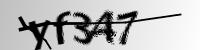

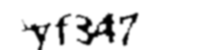

1/1 [==============================] - 0s 36ms/step
Ennustatud lahend: yf347



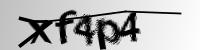

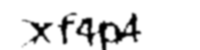

1/1 [==============================] - 0s 39ms/step
Ennustatud lahend: b74b4



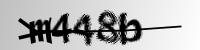

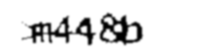

1/1 [==============================] - 0s 34ms/step
Ennustatud lahend: p442b



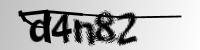

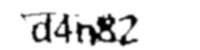

1/1 [==============================] - 0s 31ms/step
Ennustatud lahend: b4p82



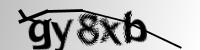

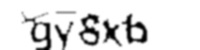

1/1 [==============================] - 0s 30ms/step
Ennustatud lahend: gy8xd



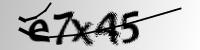

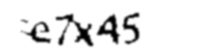

1/1 [==============================] - 0s 34ms/step
Ennustatud lahend: e7x65



In [ ]:
# Näide funktsiooni guess_captcha() tööst

filenames = ['yf347.png', 'xf4p4.png', 'm448b.png', 'd4n82.png', 'gy8xb.png', 'e7x45.png']
for filename in filenames:
  img_path = os.path.join(folder_path, filename)
  print("Ennustatud lahend:", guess_captcha(img_path))
  print()